In [65]:

import stackstac
import xarray as xr
import numpy as np
import geopandas as gpd
import pystac_client
import planetary_computer
import matplotlib.pyplot as plt


In [66]:
# connect to planetary computer stac catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [67]:
# list all collections within the catalog
collections = catalog.get_all_collections()
for collection in collections:
    print(f"{collection.id}: {collection.title}")

daymet-annual-pr: Daymet Annual Puerto Rico
daymet-daily-hi: Daymet Daily Hawaii
3dep-seamless: USGS 3DEP Seamless DEMs
3dep-lidar-dsm: USGS 3DEP Lidar Digital Surface Model
fia: Forest Inventory and Analysis
sentinel-1-rtc: Sentinel 1 Radiometrically Terrain Corrected (RTC)
gridmet: gridMET
daymet-annual-na: Daymet Annual North America
daymet-monthly-na: Daymet Monthly North America
daymet-annual-hi: Daymet Annual Hawaii
daymet-monthly-hi: Daymet Monthly Hawaii
daymet-monthly-pr: Daymet Monthly Puerto Rico
gnatsgo-tables: gNATSGO Soil Database - Tables
hgb: HGB: Harmonized Global Biomass for 2010
cop-dem-glo-30: Copernicus DEM GLO-30
cop-dem-glo-90: Copernicus DEM GLO-90
terraclimate: TerraClimate
nasa-nex-gddp-cmip6: Earth Exchange Global Daily Downscaled Projections (NEX-GDDP-CMIP6)
gpm-imerg-hhr: GPM IMERG
gnatsgo-rasters: gNATSGO Soil Database - Rasters
3dep-lidar-hag: USGS 3DEP Lidar Height above Ground
io-lulc-annual-v02: 10m Annual Land Use Land Cover (9-class) V2
goes-cmi: GOE

In [68]:
# search the catalog for S2 imagery
gdf = gpd.read_file("aoi_s.geojson") #aoi
dates = "2024-07-01/2024-08-31" #start/end dates


search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=gdf.total_bounds,
    datetime=dates,
    query={"eo:cloud_cover": {"lt": 1}},
)

items = search.item_collection()
signed_items = [planetary_computer.sign(item).to_dict() for item in items]
print(f"Returned {len(items)} Items")

Returned 5 Items


In [69]:
# create a stack of retrieved items
ds = stackstac.stack(
    items,
    assets=["B02", "B03", "B04", "B08"],
    resolution=10,
    epsg=32609,
    bounds_latlon=gdf.total_bounds,
    chunksize=2048,
)
ds

<xarray.DataArray 'stackstac-7588966bd3ba181cd5bc4399b9f710d5' (time: 5,
                                                                band: 4,
                                                                y: 4125, x: 3367)>
dask.array<fetch_raster_window, shape=(5, 4, 4125, 3367), dtype=float64, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2024-07-13...
    id                                       (time) <U54 'S2B_MSIL2A_20240713...
  * band                                     (band) <U3 'B02' 'B03' 'B04' 'B08'
  * x                                        (x) float64 9.448e+05 ... 9.784e+05
  * y                                        (y) float64 5.478e+06 ... 5.436e+06
    sat:relative_orbit                       int32 56
    ...                                       ...
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int32 32609
Attributes:
    spec:        RasterSpec(epsg=32609, bounds=(944790, 5436490, 978460, 5477...
    crs:         epsg:32609
    transform:   | 10.00, 0.00, 944790.00|\n| 0.00,-10.00, 5477740.00|\n| 0.0...
    resolution:  10

In [70]:
# create a median image from the stack
median_ds = ds.median(dim="time")
median_ds["band"] = ["B02", "B03", "B04", "B08"]
median_ds

<xarray.DataArray 'stackstac-7588966bd3ba181cd5bc4399b9f710d5' (band: 4,
                                                                y: 4125, x: 3367)>
dask.array<nanmedian, shape=(4, 4125, 3367), dtype=float64, chunksize=(1, 2020, 1660), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * band                                     (band) <U3 'B02' 'B03' 'B04' 'B08'
  * x                                        (x) float64 9.448e+05 ... 9.784e+05
  * y                                        (y) float64 5.478e+06 ... 5.436e+06
    sat:relative_orbit                       int32 56
    constellation                            <U10 'Sentinel 2'
    proj:epsg                                int32 32610
    ...                                       ...
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int32 32609

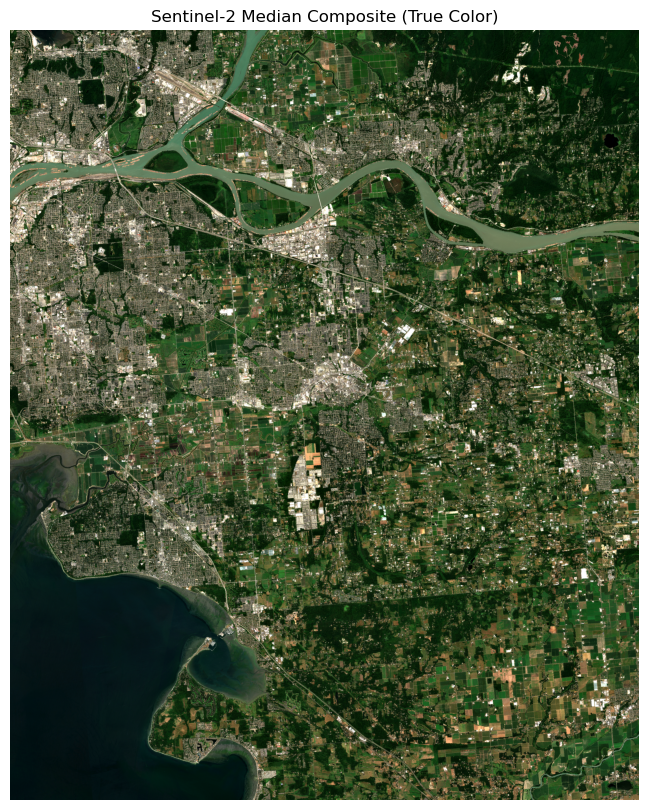

In [71]:

rgb = np.stack([
    median_ds.sel(band="B04").values,
    median_ds.sel(band="B03").values,
    median_ds.sel(band="B02").values
], axis=-1)

# Simple contrast stretch: scale to the 1st–99th percentile
p1, p99 = np.nanpercentile(rgb, (1, 99))
rgb_stretch = (rgb - p1) / (p99 - p1)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(np.clip(rgb_stretch, 0, 1))
plt.axis("off")
plt.title("Sentinel‑2 Median Composite (True Color)")
plt.show()